In [1]:
!pip install mne


In [ ]:
!wget -r -N -c -np -nH --cut-dirs=3 \
https://physionet.org/files/eegmmidb/1.0.0/


In [1]:
import mne
import os

file_path = "/kaggle/input/physionetbci2000/S001/S001R03.edf"
raw = mne.io.read_raw_edf(file_path, preload=True)

print(raw)


Extracting EDF parameters from /kaggle/input/physionetbci2000/S001/S001R03.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>


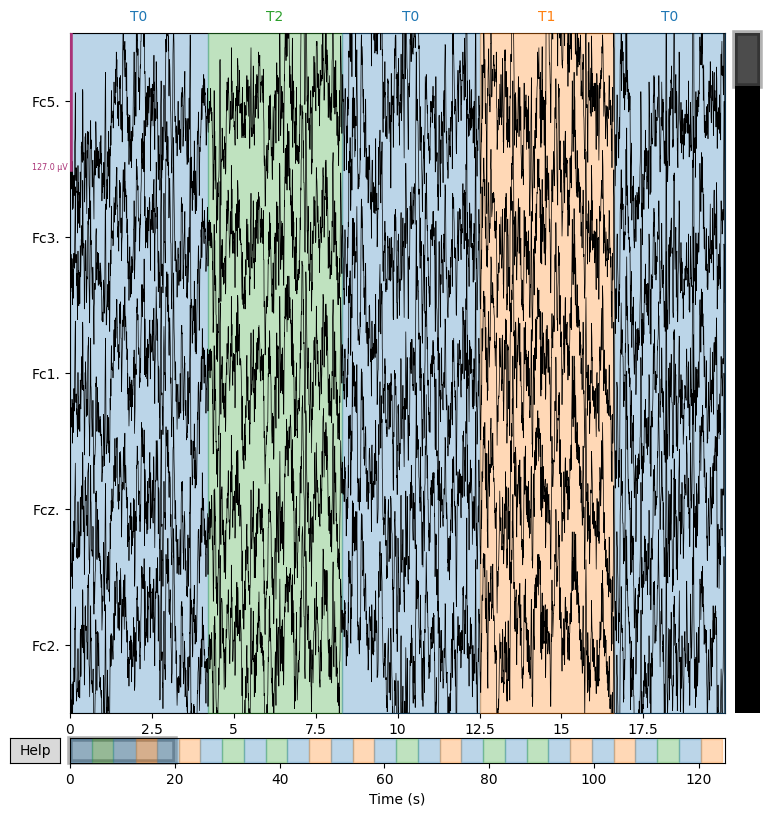

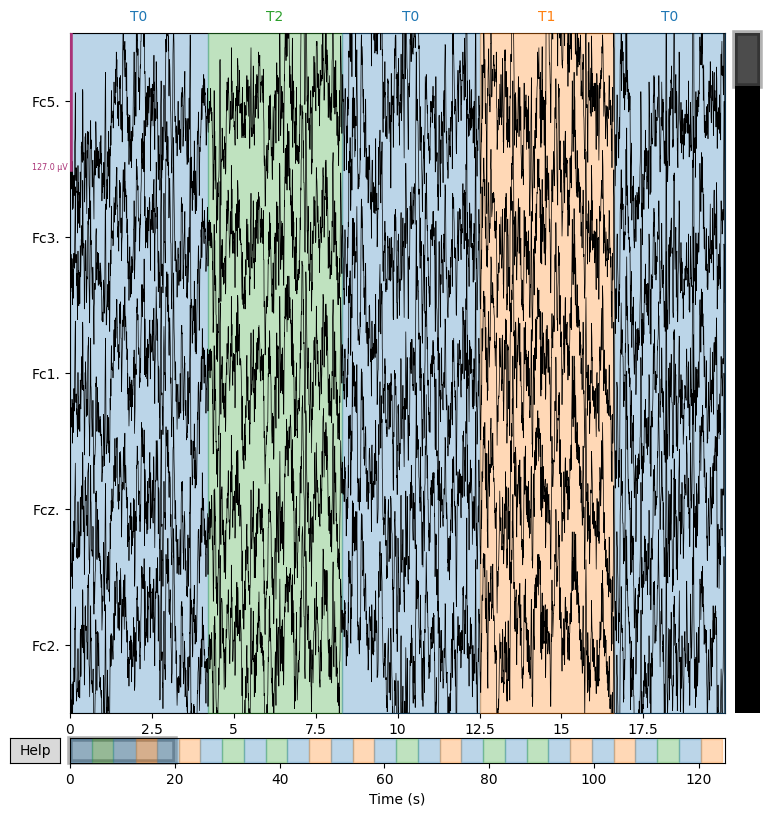

In [5]:
raw.plot(n_channels=5, duration=20, scalings='auto')


In [6]:
raw.filter(1., 40.)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

In [8]:
events, event_dict = mne.events_from_annotations(raw)
print(event_dict)


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}


In [9]:
epochs = mne.Epochs(raw, events, event_id=event_dict,
                    tmin=0, tmax=2, baseline=None, preload=True)

print(epochs)


Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 321 original time points ...
0 bad epochs dropped
<Epochs | 30 events (all good), 0 – 2 s (baseline off), ~4.8 MiB, data loaded,
 np.str_('T0'): 15
 np.str_('T1'): 8
 np.str_('T2'): 7>


In [3]:
print(epochs.ch_names[:20])


['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.']


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)


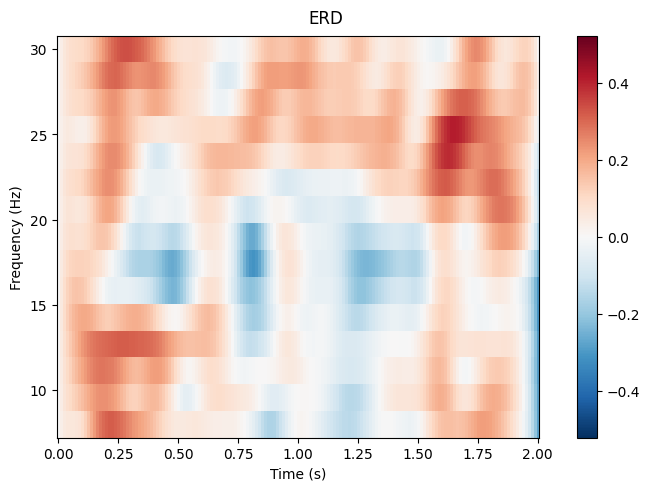

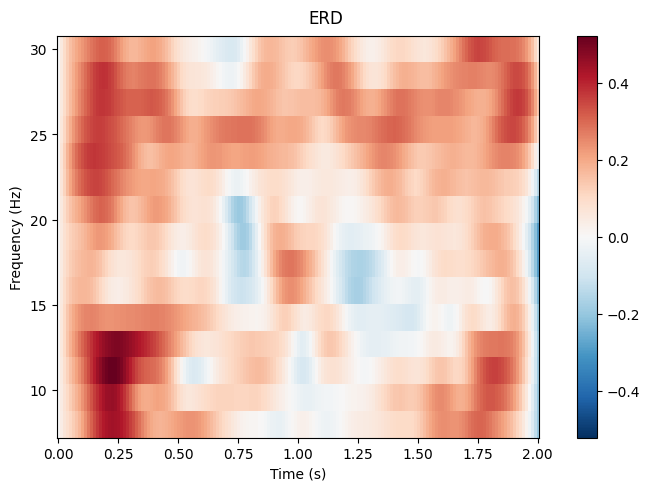

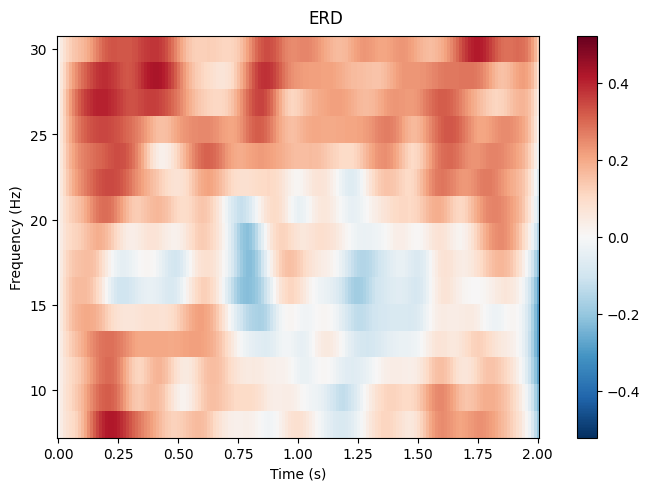

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

In [5]:
import numpy as np

picks = ["C3..", "C4..", "Cz.."]

freqs = np.linspace(8, 30, 15)   # smoother frequency range
n_cycles = freqs / 2.            # more cycles = smoother

power = mne.time_frequency.tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    picks=picks,
    use_fft=True,
    return_itc=False,
    decim=2,        # reduce noise
    average=True
)

power.plot(baseline=(-1, 0), mode='logratio', title="ERD")


In [9]:
# Get rest epochs
rest_epochs = epochs['T0']
rest_data = rest_epochs.get_data()

sfreq = epochs.info['sfreq']
bands = {"mu": (8, 12), "beta": (13, 30)}

baseline_features = []

for ch_idx in range(rest_data.shape[1]):  # per channel
    ch_signal = rest_data[:, ch_idx, :].reshape(-1)  # flatten time across trials
    psd, freqs = mne.time_frequency.psd_array_welch(
        ch_signal, sfreq=sfreq, fmin=8, fmax=30, verbose=False)

    band_vals = []
    for band in bands.values():
        idx = (freqs >= band[0]) & (freqs <= band[1])
        band_vals.append(psd[idx].mean())

    baseline_features.append(band_vals)

baseline_features = np.array(baseline_features)  # shape (channels, bands)


In [11]:
#calcuation of erd  using the baselines obtained
features = []

for epoch in data:
    epoch_features = []
    for ch_idx, ch in enumerate(epoch):
        psd, freqs = mne.time_frequency.psd_array_welch(
            ch, sfreq=sfreq, fmin=8, fmax=30, verbose=False)

        for band_i, band in enumerate(bands.values()):
            idx = (freqs >= band[0]) & (freqs <= band[1])
            task_power = psd[idx].mean()

            baseline_power = baseline_features[ch_idx, band_i]
            erd = (task_power - baseline_power) / baseline_power

            epoch_features.append(erd)

    features.append(epoch_features)

X = np.array(features)
y = epochs.events[:, -1]


In [12]:
# Keep only T1 and T2
mask = (y == 2) | (y == 3)   # depends on event_dict mapping
X_task = X[mask]
y_task = y[mask]

# Convert labels to 0/1
y_task = (y_task == y_task.max()).astype(int)


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_task = scaler.fit_transform(X_task)


In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

clf = SVC(kernel="linear", C=1)

scores = cross_val_score(clf, X_task, y_task, cv=5)

print("Cross-val accuracy:", scores.mean())


Cross-val accuracy: 0.5999999999999999


In [15]:
clf.fit(X_task, y_task)

weights = clf.coef_[0]
for i, w in enumerate(weights):
    print(f"Feature {i}: weight = {w:.3f}")



Feature 0: weight = -0.012
Feature 1: weight = -0.004
Feature 2: weight = -0.075
Feature 3: weight = -0.032
Feature 4: weight = -0.067
Feature 5: weight = -0.026
Feature 6: weight = 0.040
Feature 7: weight = 0.025
Feature 8: weight = 0.047
Feature 9: weight = 0.049
Feature 10: weight = 0.085
Feature 11: weight = 0.048
Feature 12: weight = 0.047
Feature 13: weight = -0.002
Feature 14: weight = 0.012
Feature 15: weight = 0.051
Feature 16: weight = -0.026
Feature 17: weight = 0.019
Feature 18: weight = -0.048
Feature 19: weight = 0.008
Feature 20: weight = -0.028
Feature 21: weight = -0.000
Feature 22: weight = 0.034
Feature 23: weight = 0.038
Feature 24: weight = 0.056
Feature 25: weight = 0.055
Feature 26: weight = 0.039
Feature 27: weight = 0.027
Feature 28: weight = 0.030
Feature 29: weight = 0.046
Feature 30: weight = -0.027
Feature 31: weight = 0.033
Feature 32: weight = -0.055
Feature 33: weight = 0.028
Feature 34: weight = -0.061
Feature 35: weight = 0.006
Feature 36: weight = -0.

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# Cross-validation accuracy
scores = cross_val_score(clf, X_task, y_task, cv=5)
print("Cross-validation accuracy: {:.2f}% (+/- {:.2f})".format(scores.mean()*100, scores.std()*100))

# Train on all task data
clf.fit(X_task, y_task)
y_pred = clf.predict(X_task)

print("\nTraining Accuracy:", accuracy_score(y_task, y_pred))

print("\nClassification Report:")
print(classification_report(y_task, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_task, y_pred))


Cross-validation accuracy: 60.00% (+/- 24.94)

Training Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


Confusion Matrix:
[[8 0]
 [0 7]]


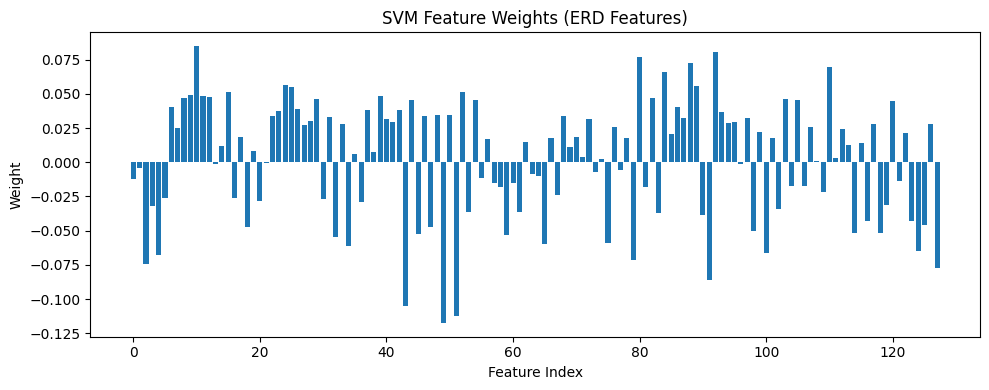

In [17]:
import matplotlib.pyplot as plt

weights = clf.coef_[0]

plt.figure(figsize=(10,4))
plt.bar(range(len(weights)), weights)
plt.title("SVM Feature Weights (ERD Features)")
plt.xlabel("Feature Index")
plt.ylabel("Weight")
plt.tight_layout()
plt.savefig("feature_weights.png")
plt.show()
